In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [444]:
# Load data
data = pd.read_csv("Data/All_data.csv").reset_index()

In [445]:
data = data.drop('index', axis=1)

In [446]:
data

,dato,togpunktlighed,koreplan_antal_planlagte_unik_tognr_togpkt_myldretid,koreplan_antal_planlagte_prod_kode_myldretid,koreplan_stdafv_antal_unik_prod_kode_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_myldretid,koreplan_stdafv_antal_unik_tognr_alle_per_time_myldretid,koreplan_antal_planlagte_unik_tognr_alle_g_meld_myldretid,koreplan_antal_planlagte_togfoelge_under_5_min_myldretid,koreplan_gns_planlagte_togfoelg_alle_min_myldretid,...,dsb_tgf_relative_sygdom,dsb_lkf_fte,dsb_lkf_sygdom,dsb_lkf_relative_sygdom,dsb_haandvaerker,dsb_fravaer,dsb_relative_fravaer,mean_temp,mean_wind_speed,acc_precip
0,2016-01-01,0.941,5.0,2.0,0.41,5.0,0.41,0.0,0.0,150.00,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
1,2016-01-01,0.882,8.0,2.0,0.82,8.0,0.82,0.0,0.0,85.57,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
2,2016-01-01,0.000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000000,67.500031,0.000000,0.000000,482.0,4.594,0.047412,3.5,2.9,0.0
3,2016-01-01,0.941,13.0,3.0,1.33,13.0,1.33,0.0,0.0,50.00,...,0.024419,186.132726,20.680000,0.111104,482.0,4.594,0.047412,4.2,2.5,0.0
4,2016-01-01,0.971,16.0,4.0,1.51,16.0,1.51,0.0,3.0,46.00,...,0.024419,186.132726,20.680000,0.111104,482.0,4.594,0.047412,4.2,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199441,2022-12-31,0.960,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.000000,29.000000,22.520000,0.776552,493.0,6.379,0.040891,7.5,5.1,8.4
199442,2022-12-31,1.000,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.039799,102.000000,23.799999,0.233333,493.0,6.379,0.040891,6.6,3.9,4.4
199443,2022-12-31,0.789,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.006712,97.000000,24.270000,0.250206,493.0,6.379,0.040891,7.6,4.5,7.2
199444,2022-12-31,0.943,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.006712,97.000000,24.270000,0.250206,493.0,6.379,0.040891,7.6,4.5,7.2


In [447]:
# Check for NaN values
np.sum(np.sum(data.isna(), axis=1))

0

In [448]:
# Make data a datetime object
data['dato'] = pd.to_datetime(data['dato'], format='%Y-%m-%d').astype('datetime64[us]')

In [449]:
def visualize_strækning(data_start, strækning):
    strækning_data = data_start[data_start['visualiseringskode'] == strækning]
    data_strækning_daily = strækning_data.groupby('dato').mean().reset_index()
    print(strækning_data.shape[0])
    plt.plot(data_strækning_daily['dato'], data_strækning_daily['togpunktlighed'])
    plt.title(f'Strækning {strækning}')
    plt.show()

In [450]:
# NOT PER DAY.

from datetime import datetime, timedelta

def delete_zeros(strækning, x):
    strækning_data = data[data['visualiseringskode'] == strækning].copy()  # Ensure a copy of the DataFrame is created
    
    strækning_data.loc[:,'zero_togpunktlighed'] = (strækning_data.loc[:,'togpunktlighed'] == 0).astype(int)
    strækning_data.loc[:,'consecutive_zeros'] = strækning_data.groupby((strækning_data.loc[:,'zero_togpunktlighed'] != strækning_data.loc[:,'zero_togpunktlighed'].shift()).cumsum())['zero_togpunktlighed'].transform('cumsum')
    
    # Find dates with more than x consecutive zeros
    dates_with_more_than_x_zeros = strækning_data[strækning_data['consecutive_zeros'] > x]['dato'].unique()
    # Find dates containing both zeros and ones
    dates_with_ones = strækning_data[strækning_data['zero_togpunktlighed'] == 0]['dato'].unique()
    # Exclude dates with both zeros and ones from dates_with_more_than_x_zeros
    dates_with_more_than_x_zeros = np.setdiff1d(dates_with_more_than_x_zeros, dates_with_ones)
    
    # Find the first index of each sequence of x or more consecutive zeros
    first_indexes = strækning_data[strækning_data['consecutive_zeros'] == x].groupby((strækning_data['consecutive_zeros'] != strækning_data['consecutive_zeros'].shift()).cumsum()).head(1).index
    
    # Remove the rows leading up to the first zero in each sequence of x or more consecutive zeros
    for idx in first_indexes:
        first_index = strækning_data.index.get_loc(idx)
        for index in strækning_data.index[first_index-x-1:first_index]:
            if (strækning_data.loc[idx,'dato'] - strækning_data.loc[index,'dato'] <= timedelta(days=x)) and (strækning_data.loc[index,'togpunktlighed'] == 0):
                dates_with_more_than_x_zeros = np.append(dates_with_more_than_x_zeros, strækning_data.loc[index,'dato'])
    
    # Filter out rows with more than x consecutive zeros
    strækning_data_filtered = strækning_data[~strækning_data['dato'].isin(dates_with_more_than_x_zeros)]
    strækning_data_filtered = strækning_data_filtered.drop(columns=['zero_togpunktlighed', 'consecutive_zeros'])
    
    visualize_strækning(data, strækning)
    visualize_strækning(strækning_data_filtered, strækning)
    return strækning_data_filtered

5114


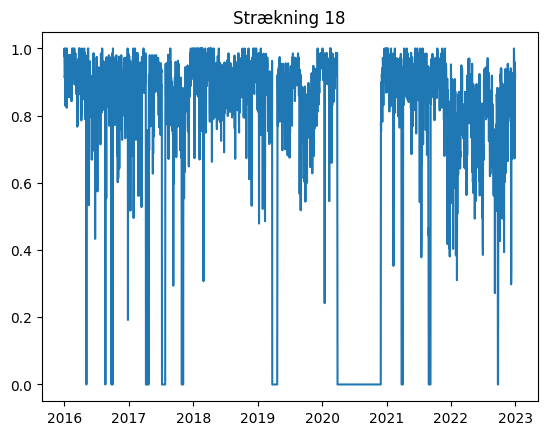

4464


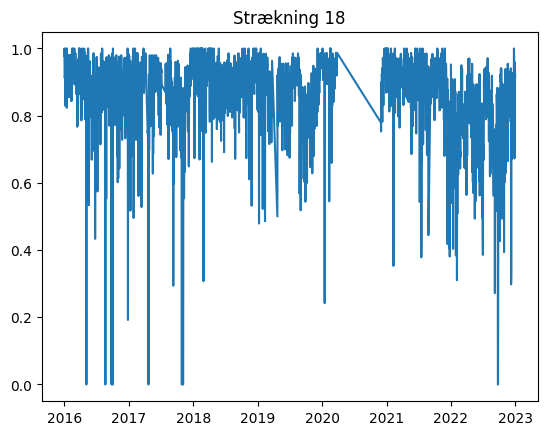

7671


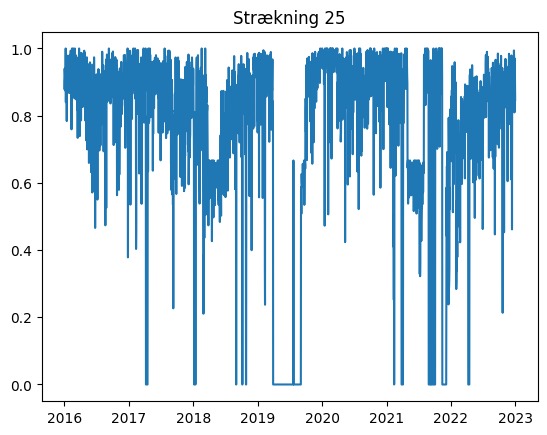

7020


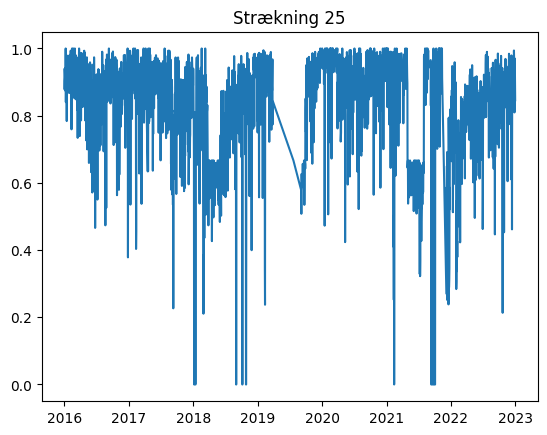

5114


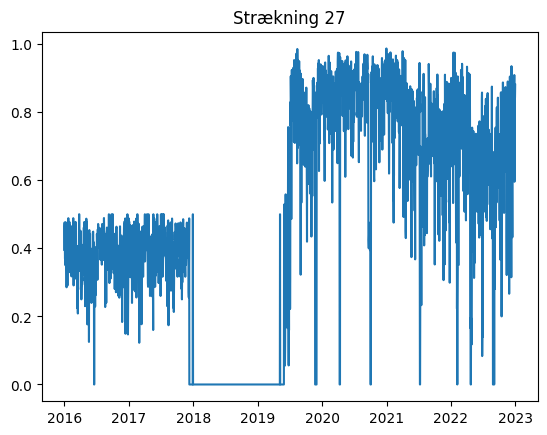

4018


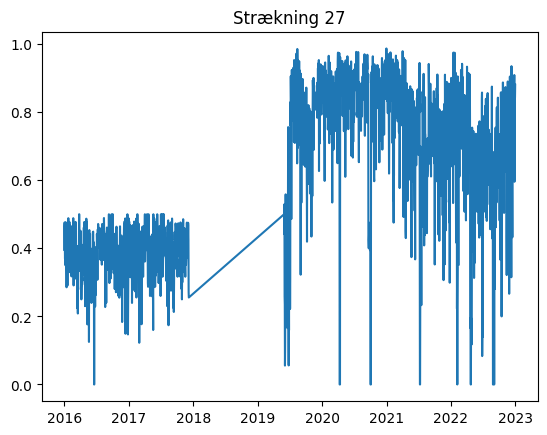

In [451]:
# BaneDanmark laver sporarbejde på:
# - strækning 18 i 2020
# - strækning 25 i 2019
# - strækning 27 i 2018-2019
for strækning in [18, 25, 27]:
    strækning_data_filtered = delete_zeros(strækning, 10)
    data.loc[data['visualiseringskode'] == strækning, :] = strækning_data_filtered
    data = data.dropna()

In [378]:
# Disse strækninger er udbydt?
# - strækning 1 i 2021
# - strækning 26
# - strækning 28

In [416]:
# PER DAY
# from datetime import datetime, timedelta

# def delete_zeros(strækning, x):
#     strækning_data = data[data['visualiseringskode'] == strækning].copy().groupby('dato').mean() # Ensure a copy of the DataFrame is created
    
#     strækning_data.loc[:,'zero_togpunktlighed'] = (strækning_data.loc[:,'togpunktlighed'] == 0).astype(int)
#     strækning_data.loc[:,'consecutive_zeros'] = strækning_data.groupby((strækning_data.loc[:,'zero_togpunktlighed'] != strækning_data.loc[:,'zero_togpunktlighed'].shift()).cumsum())['zero_togpunktlighed'].transform('cumsum')
    
#     dates_with_more_than_x_zeros = strækning_data[strækning_data['consecutive_zeros'] > x].index.unique()
    

#     # Find the first index of each sequence of x or more consecutive zeros
#     first_indexes = strækning_data[strækning_data['consecutive_zeros'] == x].groupby((strækning_data['consecutive_zeros'] != strækning_data['consecutive_zeros'].shift()).cumsum()).head(1).index
    
#     # Remove the rows leading up to the first zero in each sequence of x or more consecutive zeros
#     for idx in first_indexes:
#         for j in pd.date_range(idx-timedelta(days=x-1), idx):
#             dates_with_more_than_x_zeros = np.append(dates_with_more_than_x_zeros, j)


#     strækning_data_filtered = strækning_data[~strækning_data.index.isin(dates_with_more_than_x_zeros)]
#     strækning_data_filtered = strækning_data_filtered.drop(columns=['zero_togpunktlighed', 'consecutive_zeros'])
    
#     visualize_strækning(data, strækning)
#     visualize_strækning(strækning_data_filtered, strækning)
#     return strækning_data_filtered

In [379]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
ohe = ColumnTransformer(
    transformers=[("ohe", encoder, ["visualiseringskode", "station"]),], 
    remainder="passthrough",
    verbose_feature_names_out=False
)    # FLERE CATEGORICAL VARIABLES.
ohe.set_output(transform="pandas")

ohe.fit(data)
data_t = ohe.transform(data)


In [383]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()
data_t.iloc[:,77:] = scaler.fit_transform(data_t.iloc[:,77:])


In [384]:
data_t.to_csv('Data/Cleaned_data.csv', index=False)

In [385]:
data_t

,visualiseringskode_1.0,visualiseringskode_2.0,visualiseringskode_3.0,visualiseringskode_4.0,visualiseringskode_5.0,visualiseringskode_6.0,visualiseringskode_7.0,visualiseringskode_8.0,visualiseringskode_9.0,visualiseringskode_10.0,...,dsb_tgf_fte,dsb_tgf_raadighed,dsb_tgf_sygdom,dsb_tgf_relative_sygdom,dsb_lkf_fte,dsb_lkf_sygdom,dsb_lkf_relative_sygdom,dsb_haandvaerker,dsb_fravaer,dsb_relative_fravaer
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116212,0.000000,0.000000,0.000000,0.146547,0.000000,0.000000,0.692884,0.068160,0.076218
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116212,0.000000,0.000000,0.000000,0.146547,0.000000,0.000000,0.692884,0.068160,0.076218
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116212,0.000000,0.000000,0.000000,0.146547,0.000000,0.000000,0.692884,0.068160,0.076218
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.393672,0.339183,0.090909,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.393672,0.339183,0.090909,0.095326,0.404108,0.036875,0.015014,0.692884,0.068160,0.076218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.062961,0.040156,0.104939,0.734082,0.099190,0.063604
199442,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.241537,0.097814,0.090909,0.155368,0.221449,0.042439,0.031532,0.734082,0.099190,0.063604
199443,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.358029,0.099540,0.022727,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604
199444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.358029,0.099540,0.022727,0.026204,0.210594,0.043277,0.033812,0.734082,0.099190,0.063604
